In [9]:
# CNN : 개/고양이 이미지 분류
import os, zipfile    # os : 운영체제와 상호 작용 라이브러리 / zip : 압축 해제 라이브러리
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(1)
tf.random.set_seed(1)

In [10]:
data_url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"

zip_path = tf.keras.utils.get_file(    # 압축 파일 내려받기
    fname='cats_and_dogs_filtered.zip',    # 저장할 파일 이름
    origin=data_url,    # 다운로드 원본 url
    extract=False,    # 압축 풀지 않겠다
    cache_dir='.',    # 
    cache_subdir=''    # 현재 작업 디렉터리 바로 아래에 파일을 두도록 지정
)
print(zip_path)

./cats_and_dogs_filtered.zip


In [11]:
if not os.path.exists('./cat_and_dogs_filtered.zip'):   # 압축이 풀려있지 않다면
     with zipfile.ZipFile(zip_path, 'r') as obj:    # with : 블록을 빠져나오면 자동으로 닫힌다.
         obj.extractall(".")   # zip 안의 모든 파일/폴더를 현재 작업 디렉터리(".")에 한꺼번에 풀어 놓는다.
         print('extract ok~~')

extract ok~~


In [12]:
# 경로 정보 확인
PATH = './cats_and_dogs_filtered'   # 이미지가 있는 root
train_dir = os.path.join(PATH, 'train')   # 학습 폴더명
validation_dir = os.path.join(PATH, 'validation')   # 검증 폴더명


BATCH_SIZE = 32    # RAM 용량, GPU가 좋을 경우 더 높여도 된다.
EPOCHS = 15
IMG_HEIGHT, IMG_WIDTH = 150, 150

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(validation_dir, 'cats')
valid_dogs_dir = os.path.join(validation_dir, 'dogs')

for p in [train_dir, train_cats_dir, train_dogs_dir, valid_cats_dir,valid_dogs_dir]:
    print((p, '->', os.path.exists(p)))
    
# 개수
print('cats(train):', len(os.listdir(train_cats_dir)))
print('dogs(train):', len(os.listdir(train_dogs_dir)))
print('cats(valid):', len(os.listdir(valid_cats_dir)))
print('dogs(valid):', len(os.listdir(valid_dogs_dir)))

('./cats_and_dogs_filtered/train', '->', True)
('./cats_and_dogs_filtered/train/cats', '->', True)
('./cats_and_dogs_filtered/train/dogs', '->', True)
('./cats_and_dogs_filtered/validation/cats', '->', True)
('./cats_and_dogs_filtered/validation/dogs', '->', True)
cats(train): 1000
dogs(train): 1000
cats(valid): 500
dogs(valid): 500


In [13]:
# 제너레이터 준비(증강, 스케일링)
# 데이터 적어서 늘리기 위함

train_datagen = ImageDataGenerator(    # 회전, 스케일링
    rescale = 1./255,   # 0 ~ 1 사이로 스케일
    rotation_range = 15,    # 180까지 가능
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)   # 검증 데이터는 스케일만 하는 것이 바람직

train_data = train_datagen.flow_from_directory(   # 폴더에 대해 자동으로 라벨링됨
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode = 'binary',   # 이진 분류 - binary, 다항 분류 - categorical
    shuffle=True,
)

valid_data = valid_datagen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode = 'binary',
    shuffle=False    # 검증 데이터 shuffle 불필요
)

print('class(label) index:', train_data.class_indices)
print('val class(label) index:', valid_data.class_indices)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
class(label) index: {'cats': 0, 'dogs': 1}
val class(label) index: {'cats': 0, 'dogs': 1}


{0: 'cats', 1: 'dogs'}


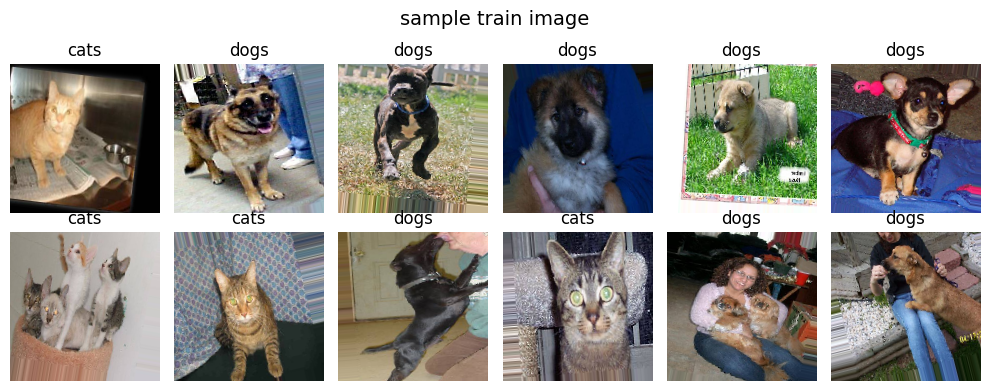

In [14]:
# 강아지, 고양이 시각화
imgs, labels = next(train_data)
n_show = min(12, imgs.shape[0])
cols = 6    # 열
rows = int(np.ceil(n_show / cols))   # 행
idx_to_name = {v:k for k,v in train_data.class_indices.items()}
print(idx_to_name)   # {'cats': 0, 'dogs': 1} -> {0: 'cats', 1: 'dogs'}

plt.figure(figsize=(10, 2 * rows))
for i in range(n_show):
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(imgs[i])
    ax.set_title(f"{idx_to_name[int(labels[i])]}")
    ax.axis('off')

plt.suptitle('sample train image', fontsize=14)
plt.tight_layout()
plt.show()
plt.close()

In [46]:
# 모델 정의
model = Sequential([
    Input((IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(32, 3, padding='same', activation='leaky_relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(64, 3, padding='same', activation='leaky_relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),
    Conv2D(128, 3, padding='same', activation='leaky_relu'),
    BatchNormalization(),
    MaxPooling2D(),
    Dropout(0.25),
    
    # 2D -> 1D
    Flatten(),
    Dense(256, activation='leaky_relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='leaky_relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)              │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,728,769 (40.93 MB)

 Trainable params: 10,727,809 (40.92 MB)

 Non-trainable params: 960 (3.75 KB)

In [47]:
# Callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping

os.makedirs('chkpoint', exist_ok=True)
ckpt = ModelCheckpoint(
    filepath='chkpoint/catdogmodel.keras',
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=2
)

es = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# 학습
history = model.fit(train_data, epochs=25, validation_data=valid_data, callbacks=[ckpt, es], verbose=2)

# 평가
val_loss, val_acc = model.evaluate(valid_data, verbose=0)
print(f"val_loss : {val_loss:.4f}")
print(f"val_acc : {val_acc:.4f}")


Epoch 1/30

Epoch 1: val_accuracy improved from None to 0.50000, saving model to chkpoint/catdogmodel.keras
63/63 - 17s - 272ms/step - accuracy: 0.5440 - loss: 0.9579 - val_accuracy: 0.5000 - val_loss: 0.7694
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.50000
63/63 - 10s - 153ms/step - accuracy: 0.5835 - loss: 0.7287 - val_accuracy: 0.5000 - val_loss: 1.3479
Epoch 3/30

Epoch 3: val_accuracy did not improve from 0.50000
63/63 - 9s - 149ms/step - accuracy: 0.6005 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 1.0567
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.50000
63/63 - 10s - 151ms/step - accuracy: 0.6185 - loss: 0.6735 - val_accuracy: 0.5000 - val_loss: 0.9423
Epoch 5/30

Epoch 5: val_accuracy improved from 0.50000 to 0.55200, saving model to chkpoint/catdogmodel.keras
63/63 - 10s - 153ms/step - accuracy: 0.6625 - loss: 0.6288 - val_accuracy: 0.5520 - val_loss: 0.7207
Epoch 6/30

Epoch 6: val_accuracy improved from 0.55200 to 0.57100, saving model to chkp

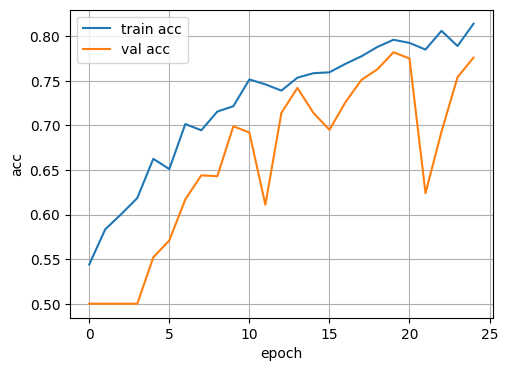

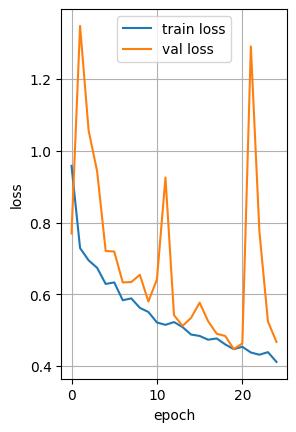

In [48]:
# 평가에 대한 시각화(acc, loss)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.grid()
plt.show()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.grid()
plt.show()

Found 1000 images belonging to 2 classes.
[0.24956624 0.15799135 0.40463603 0.09587724 0.10348843 0.2854217 ] [0.8320034  0.97731346 0.33223963 0.78412193 0.7161678  0.6981361 ]


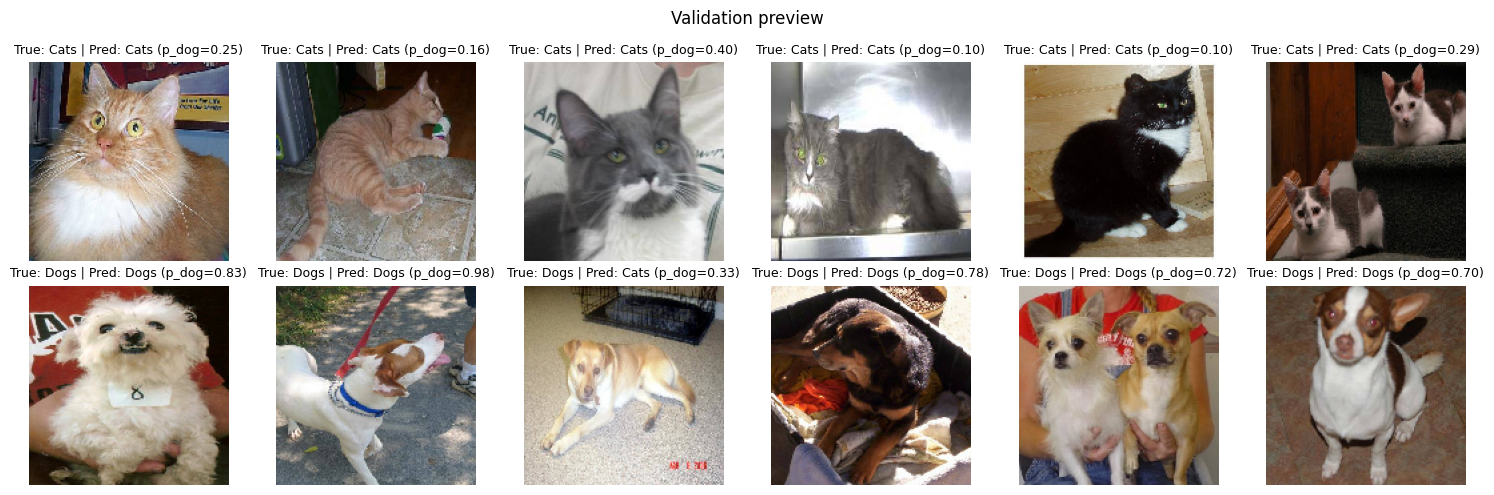

In [49]:
# 검증 배치 예측
preview_gen = ImageDataGenerator(rescale=1./255)
preview_flow = preview_gen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode = 'binary',
    shuffle=True,
    seed=123
)

# 예측용 개/고양이 6장 읽기
n_each = 6   # 고양이/개 각각 n개 모일 때까지 여러 배치 이어 받기
cats_imgs, dogs_imgs = [], []
while len(cats_imgs) < n_each or len(dogs_imgs) < n_each:
    imgs, labels = next(preview_flow)    # 섞인 배치 자료
    for im, lb in zip(imgs, labels.ravel()):
        if lb == 0 and len(cats_imgs) < n_each:
            cats_imgs.append(im)
        elif lb == 1 and len(dogs_imgs) < n_each:
            dogs_imgs.append(im)
        
        if len(cats_imgs) >= n_each and len(dogs_imgs) >= n_each:
            break

# 예측
cats_probs = model.predict(np.array(cats_imgs), verbose=0).ravel()
dogs_probs = model.predict(np.array(dogs_imgs), verbose=0).ravel()
print(cats_probs, dogs_probs)   # 확률값으로 출력

# 예측 결과 시각화
rows, cols = 2, n_each
plt.figure(figsize=(2.5*cols, 5))

for i in range(n_each):
    # cats row
    ax = plt.subplot(rows, cols, i + 1)
    ax.imshow(cats_imgs[i])
    ax.axis('off')
    p = cats_probs[i]
    ax.set_title(f"True: Cats | Pred: {'Dogs' if p >= 0.5 else 'Cats'} (p_dog={p:.2f})", fontsize=9)
    
    # dogs row
    ax = plt.subplot(rows, cols, cols+ i + 1)
    ax.imshow(dogs_imgs[i])
    ax.axis('off')
    p = dogs_probs[i]
    ax.set_title(f"True: Dogs | Pred: {'Dogs' if p >= 0.5 else 'Cats'} (p_dog={p:.2f})", fontsize=9)

plt.suptitle('Validation preview', fontsize=12)
plt.tight_layout()
plt.show()
plt.close()